<a href="https://colab.research.google.com/github/joycerlz/distilbert-text-classification/blob/main/distilbert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning DistilBERT for Multiclass Text Classification

## Model - 'distilbert-base-uncased'


In [ ]:
!pip  install transformers

In [ ]:
!pip install --upgrade tensorflow_hub

In [ ]:
!pip install tensorflow keras pickle

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TextClassificationPipeline
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf
import pandas as pd
import numpy as np
import json
import gc
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from plotly.offline import iplot

from tensorflow import keras
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import files

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('augmented_df.csv')
df.head()

,text,labels
0,Am easily intimidated.,4
1,Get irritated easily.,4
2,Am always prepared.,4
3,Feel sympathy for those who are worse off than...,4
4,Get upset easily.,4


In [ ]:
df.shape

(1665, 2)

# Split to train, validation, and test

In [ ]:
data_texts = df['text'].to_list()
data_labels = df['labels'].to_list()

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.15, random_state=0)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.15, random_state=0)

In [ ]:
print("Train set size:", len(train_texts))
print("Validation set size:", len(val_texts))
print("Test set size:", len(test_texts))

Train set size: 1202
Validation set size: 250
Test set size: 213


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices( (dict(train_encodings), train_labels) )
val_dataset = tf.data.Dataset.from_tensor_slices( (dict(val_encodings), val_labels) )
test_dataset = tf.data.Dataset.from_tensor_slices( (dict(test_encodings), test_labels) )

train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)

# Fine-tuning with the TFTrainer class

**NOTE**

If encountered error "No module named 'keras.saving.hdf5_format'"

Steps to fix:

1. Expand this error traces (from the frames)
2. Go to the *transformers/modeling_tf_utils.py* file
3. Comment out the line (39) "```from keras.saving.hdf5_format import save_attributes_to_hdf5_group```"
4. Re-run

[Source](https://stackoverflow.com/questions/74586892/no-module-named-keras-saving-hdf5-format)

In [ ]:
# from transformers import TFDistilBertForSequenceClassification

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)

In [ ]:
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

Epoch 1/10
76/76 [==============================] - 332s 4s/step - loss: 1.5114 - accuracy: 0.3544 - val_loss: 1.2540 - val_accuracy: 0.5080
Epoch 2/10
76/76 [==============================] - 357s 5s/step - loss: 0.8124 - accuracy: 0.7504 - val_loss: 0.4971 - val_accuracy: 0.8160
Epoch 3/10
76/76 [==============================] - 346s 5s/step - loss: 0.2598 - accuracy: 0.9368 - val_loss: 0.1558 - val_accuracy: 0.9520
Epoch 4/10
76/76 [==============================] - 337s 4s/step - loss: 0.0673 - accuracy: 0.9884 - val_loss: 0.1133 - val_accuracy: 0.9680
Epoch 5/10
76/76 [==============================] - 343s 5s/step - loss: 0.0431 - accuracy: 0.9925 - val_loss: 0.0975 - val_accuracy: 0.9760
Epoch 6/10
76/76 [==============================] - 329s 4s/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 0.9800
Epoch 7/10
76/76 [==============================] - 331s 4s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0606 - val_accuracy: 0.9840
Epoch 8/10
76

In [ ]:
benchmarks = model.evaluate(test_dataset, return_dict=True, batch_size=16)
print(benchmarks)

14/14 [==============================] - 12s 785ms/step - loss: 0.0521 - accuracy: 0.9859
{'loss': 0.05208521708846092, 'accuracy': 0.98591548204422}


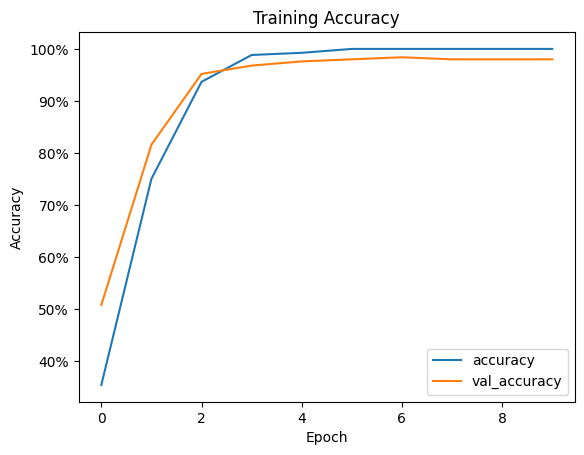

In [ ]:
def plotAccuracy(model_history):
  plt.plot(model_history.history['accuracy'], label= 'accuracy')
  plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')
  plt.legend()

plotAccuracy(model_history)

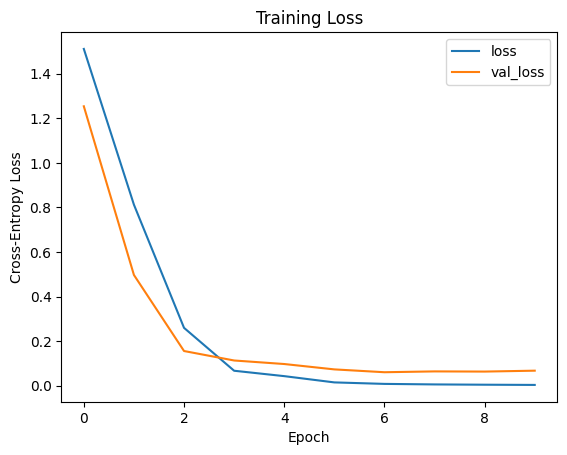

In [ ]:
def plotLoss(model_history):
  plt.plot(model_history.history['loss'], label= 'loss')
  plt.plot(model_history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-Entropy Loss')
  plt.title('Training Loss')
  plt.legend()

plotLoss(model_history)

In [ ]:
tokenized_test = tokenizer(test_texts, padding=True, truncation=True, return_tensors="tf")
output = model.predict(tokenized_test)[0]
y_pred = np.argmax(output, axis=1)

print(classification_report(test_labels, y_pred))

7/7 [==============================] - 9s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       1.00      1.00      1.00        48
           2       0.95      0.97      0.96        36
           3       1.00      0.98      0.99        41
           4       0.97      1.00      0.99        39

    accuracy                           0.99       213
   macro avg       0.98      0.99      0.98       213
weighted avg       0.99      0.99      0.99       213



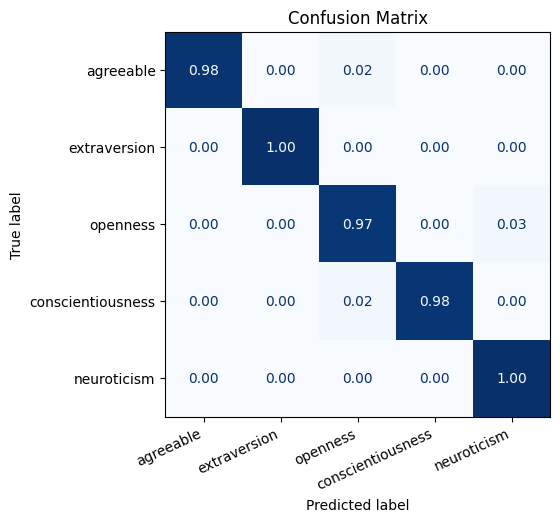

In [ ]:
def plot_confusion_matrix(y_pred, y_true):
  labels = ["agreeable","extraversion","openness","conscientiousness","neuroticism"]
  cm = confusion_matrix(y_true, y_pred, normalize="true", labels=range(len(labels)))
  _, ax = plt.subplots(figsize=(5, 5))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion Matrix")
  ax.set_xticklabels(labels, rotation=25, ha="right")
  plt.show()

plot_confusion_matrix(y_pred, test_labels)

# Saving & Loading the model

In [ ]:
model.save("/distilbert-bigfive-v2")

In [ ]:
# compress the folder and download
!zip -r distilbertv2.zip /distilbert-bigfive-v2
files.download('distilbertv2.zip')

updating: distilbert-bigfive-v2/ (stored 0%)
updating: distilbert-bigfive-v2/variables/ (stored 0%)
updating: distilbert-bigfive-v2/variables/variables.index (deflated 78%)
updating: distilbert-bigfive-v2/variables/variables.data-00000-of-00001 (deflated 29%)
updating: distilbert-bigfive-v2/keras_metadata.pb (deflated 94%)
updating: distilbert-bigfive-v2/saved_model.pb (deflated 92%)
updating: distilbert-bigfive-v2/fingerprint.pb (stored 0%)
updating: distilbert-bigfive-v2/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# save_dir = "/saved_models"
# os.makedirs(save_dir, exist_ok=True)
# model.save_pretrained(save_dir)
# tokenizer.save_pretrained(save_dir)

# Loading Pre-Trained Model

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_dir)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_dir)

# Inferencing with Pytorch

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf = True )

In [ ]:
predict_input_pt = tokenizer_fine_tuned_pt(test_text, truncation = True, padding = True, return_tensors = 'pt' )
ouput_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt